# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Построим модель с максимально большим значением *accuracy*. 

## 1. Откроем и изучим файл

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# прочитаем данные
users = pd.read_csv('users_behavior.csv')
users.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
# проверим формат данных и наличие пропусков
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Построим матрицу корреляций, чтобы проверить, не коррелируют ли признаки между собой.

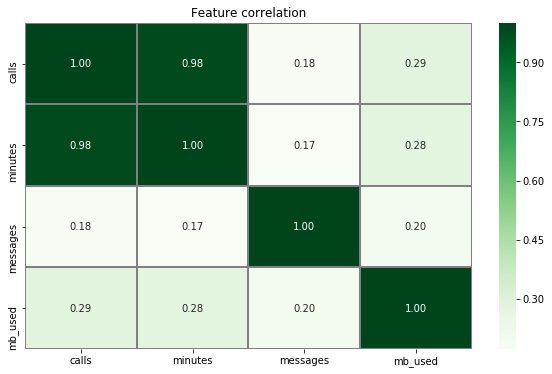

In [4]:
cm = users.drop('is_ultra', axis=1).corr() #вычисляем матрицу корреляций
plt.figure(figsize=(10, 6))
ax = sns.heatmap(cm, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="Greens")
ax.set_title('Feature correlation')
plt.show()

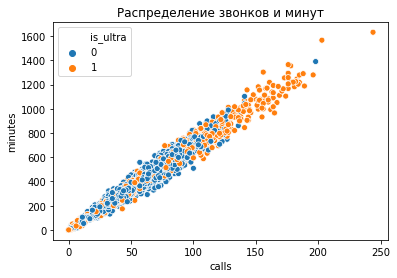

In [5]:
sns.scatterplot(users['calls'], users['minutes'], hue=users['is_ultra'])
plt.title('Распределение звонков и минут')
plt.show()

Как из матрицы корреляций, так и из графика распределения видим, что число звонков и общая продолжительность звонков в минутах очень сильно коррелируют между собой. Выбросим один из этих признаков, чтобы не засорять модель.

In [6]:
users = users.drop('calls', axis=1)

Проверим оставшиеся признаки.

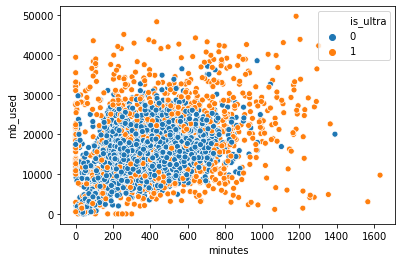

In [7]:
sns.scatterplot(users['minutes'], users['mb_used'], hue=users['is_ultra'])
plt.title('Распределение минут и мегабайт')
plt.show()

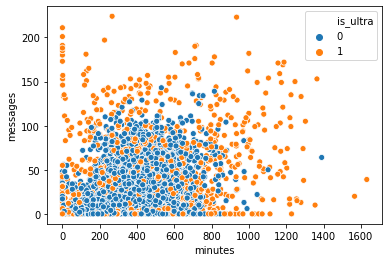

In [8]:
sns.scatterplot(users['minutes'], users['messages'], hue=users['is_ultra'])
plt.title('Распределение минут и сообщений')
plt.show()

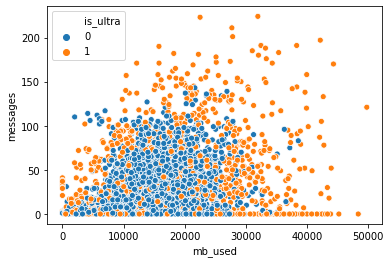

In [9]:
sns.scatterplot(users['mb_used'], users['messages'], hue=users['is_ultra'])
plt.title('Распределение мегабайт и сообщений')
plt.show()

Оставшиеся пары признаков не мультиколлинеарны, оставляем их.

## 2. Разбейте данные на выборки

In [10]:
X = users.drop('is_ultra', axis=1) # выделим признаки
y = users['is_ultra'] # выделим целевую переменную

In [11]:
# делим наблюдения на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print(X_train.shape) # посмотрим на размеры выборок
print(X_test.shape)

(2410, 3)
(804, 3)


## 3. Исследуем модели

Создадим три модели: решающее дерево, случайный лес и логистическая регрессия. Автоматизируем процесс подбора лучших гиперпараметров при помощи GridSearch.

In [12]:
search1 = GridSearchCV(DecisionTreeClassifier(random_state=1), {'max_depth': range(5, 51, 5), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 10)})
search1.fit(X_train, y_train)
best_tree = search1.best_estimator_
predictions1 = best_tree.predict(X_test)

print('Точность модели DecisionTreeClassifier - {:.3f}'.format(accuracy_score(y_test, predictions1)))

search2 = GridSearchCV(RandomForestClassifier(random_state=1), {'n_estimators': range(10, 100, 5)})
search2.fit(X_train, y_train)
best_forest = search2.best_estimator_
predictions2 = best_forest.predict(X_test)

print('Точность модели RandomForestClassifier - {:.3f}'.format(accuracy_score(y_test, predictions2)))

regr_model = LogisticRegression(random_state=1)
regr_model.fit(X_train, y_train)
predictions3 = regr_model.predict(X_test)

print('Точность модели LogisticRegression - {:.3f}'.format(accuracy_score(y_test, predictions3)))

Точность модели DecisionTreeClassifier - 0.772
Точность модели RandomForestClassifier - 0.790
Точность модели LogisticRegression - 0.684


Видим, что на заданных параметрах DecisionTreeClassifier и RandomForestClassifier довольно близки по показателю `accuracy_score`.

Предлагаю выбрать RandomForestClassifier как менее быстрый, но в целом более надежный класс.

Заодно посмотрим на гиперпараметры лучших моделей.

In [13]:
search1.best_params_

{'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}

In [14]:
search2.best_params_

{'n_estimators': 95}

## 4. Проверим модель на тестовой выборке

Как показано выше, и у модели DecisionTreeClassifier, и у модели RandomForestClassifier точность на тестовой выборке превышает 0.75 и составляет около 0.77 и 0.79 соответственно.

#### Вывод

Нами было создано три модели: решающего дерева, случайного леса и логистической регресии. Путем подбора параметров мы выяснили, что лучший результат показывают DecisionTreeClassifier (с глубиной - 5, минимальным размером листка - 8, и минимальным количеством наблюдений для деления - 2) и RandomForestClassifier (с количеством деревьев - 95).

При этом точность оптимальных моделей на тестовой выборке превысила 0.75.

## 5. Проверим модели на адекватность

In [25]:
users['is_ultra'].value_counts() / users.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Как мы видим, ноль соответствует 69 % пользователей. Точность нашей модели RandomForestClassifier (79%) превышает этот показатель и, соответственно, модель адекватна для использования в работе.